# Hedging and Control Variates in Monte-Carlo Simulations

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In [1]:
#Package Import
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')

In [2]:
#Import functions associated with Black-Scholes Equations

%run functions_black_scholes.py


import types

# List all functions in functions_black_scholes.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])


['bs_call', 'bs_put', 'bs_call_delta', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta', 'bs_call_rho', 'bs_put_rho']


In [3]:
help(bs_call)

Help on function bs_call in module __main__:

bs_call(S0, K, sigma, t, r=0)
    Computes the Black-Scholes price of a European call option.
    
    Parameters:
        S0 (float): Current asset price
        K (float): Strike price
        sigma (float): Annualized volatility (standard deviation of log returns)
        t (float): Time to expiration (in years)
        r (float): Risk-free interest rate (annualized)
    
    Returns:
        float: Call option price



In [4]:
help(bs_call_delta)

Help on function bs_call_delta in module __main__:

bs_call_delta(S0, K, sigma, t, r)
    Returns the Delta (sensitivity to spot price) of a European call option
    under Black-Scholes assumptions.
    
    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility of the stock
        t (float): Time to maturity (in years)
        r (float): Risk-free interest rate
    
    Returns:
        float: Delta of Call Option



### Delta Based Control Variants in Monte-Carlo Simulation


Consider a call option on a stock at time $0$ that expires at time $t$. Assume the stock path follows a risk-neutral Geometric Brownian Motion:

$$S_t = S_0e^{\left(r -\frac{\sigma^2}{2} \right)t + \sigma\sqrt{t}\mathcal{N}(0,1)}.$$


Let $0 = t_0<t_1<\cdots<t_{n-1}<t_n = t.$ Then the expected payoff of the call option discounted to time $0$ can be simulated as

$$\max(S_t-K,0)e^{-rt} - \sum_{i=1}^n (S_{t_i}- e^{r(t_i-t_{i-1})}S_{t_{i-1}})\Delta_{C_{t_{i-1}}}e^{-rt_i}.$$

Where
1) $\Delta_{C_{t_{i-1}}}$ is the rate of change of the value of the call option at time $t_{i-1}$ with respect to the price of the stock $S_{t_{i-1}}$ at time $t_{i-1}$.

2) $(S_{t_i}- e^{r(t_i-t_{i-1})S_{t_{i-1}}})\Delta_{C_{i-1}}e^{-rt_i}$ is the profit of holding $\Delta_{C_{t_{i-1}}}$ shares of stock from time $t_{i-1}$ to time $t_{i}$ discounted to time $0$.

3) Each of the "heding terms" $(S_{t_i}- e^{r(t_i-t_{i-1})S_{t_{i-1}}})\Delta_{C_{i-1}}e^{-rt_i}$ has expected value $0$ and is perfectly correlated with $C_{t_{i-1}}$ by design with respect to the price of the underlying stock.

4) Subtracting the hedging terms introduce a **control variant** into the simulation and reduces overall variance in the simulated values, therefore producing a more reliable simulation whose mean is more likely to accurately reflect the true Black-Scholes price of the call option.

In [13]:
#Simulate 1000 payoff distributions of a call option 
#with one year to expiration and 5 Delta based control variants

S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04

n_sims = 1000
n_hedges = 5


#Path simulation
#Create random noise for n_sims number of paths with n_hedges steps in simulated stock movements

noise = np.random.normal(0,1,(n_sims,n_hedges))


#time interval between each step in simulated path
dt = t/n_hedges

increments = (r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

log_returns = np.cumsum(increments, axis = 1)

paths = S0*np.exp(log_returns)



#Simulate call payouts discounted to time 0

path_end_points = paths[:,-1]

call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



#Simulate stock profits at each interval

## profit from start to first step discounted to time 0
### We are going to cheat at the current moment in our simulation
### We will use the Black-Scholes formula to find Delta,
### We'll simulate Delta later

delta_start = bs_call_delta(S0,K,sigma,t,r)

paths_first_steps = paths[:,0]

first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

stock_profits = []

stock_profits.append(first_stock_profits)




## stock profits in intermediate steps

for i in range(1,n_hedges):
    stock_start = paths[:,i-1]
    stock_end = paths[:,i]
    tte = t-i*dt
    deltas = bs_call_delta(stock_start, K, sigma, tte, r)
    
    
    stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)
    
    
    stock_profits.append(stock_profit)
    

total_stock_profit = np.sum(stock_profits, axis = 0)

profits_hedged = call_payouts - total_stock_profit

std_err = np.std(profits_hedged)/np.sqrt(n_sims)

#Comparison of simulated value with Black-Scholes

print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations and \
{n_hedges} control variants and standard error: {std_err:.6f}')

print('------'*17)
print('------'*17)


print(f'Black Scholes Price of Call Option: ${bs_call(S0,K,sigma,t,r):.2f}')


Simulated-Black Scholes Price: $7.56  with 1000 simulations and 5 control variants and standard error: 0.119172
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Black Scholes Price of Call Option: $7.48


### Hedging and Drift Terms

Theoretically, the expected value of a call option under Black-Scholes assumptions, with a drift term, agrees with the value of the call option under the risk-neutral model of the stock path. We can visually demonstrate how regularly hedging causes this to happen.

In [15]:
#Compare simulated call value means with different number of hedges with nonzero drift
S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04
mu = .35 #Significant drift of stock movement and corresponds to approx 42% annual return

n_sims = 1000



hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

for n_hedges in hedging_numbers:
    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_call_delta(S0,K,sigma,t,r)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_call_delta(stock_start, K, sigma, tte, r)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit

    std_err = np.std(profits_hedged)/np.sqrt(n_sims)
    


    #Comparison of simulated value with Black-Scholes

    print(f'Simulated-Black Scholes Price: ${np.mean(profits_hedged):.2f}  with {n_sims} simulations and \
{n_hedges} control variants and standard error: {std_err:.6f}')

    print('------'*17)
    print('------'*17)

    
print(f'Black Scholes Price of Call Option: ${bs_call(S0,K,sigma,t,r):.2f}')


Simulated-Black Scholes Price: $3.61  with 1000 simulations and 1 control variants and standard error: 0.148827
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Simulated-Black Scholes Price: $6.64  with 1000 simulations and 5 control variants and standard error: 0.111374
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Simulated-Black Scholes Price: $7.32  with 1000 simulations and 25 control variants and standard error: 0.054444
------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
Simulated-Black Scholes Price: $7.43  with 10

In [45]:
#Write function that simulates black-schole price of call option using delta-based control variants
#Stock movements are allowed to have drift

S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04
mu = .35 #Drift of stock movement

n_sims = 1000
n_hedges = 50


def bs_MC_call(S0, K, sigma, r, t, mu = 0, n_sims = 2500, n_hedges = 50):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    
    Warning:
    This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    """
    #We will adjust this function later in the notebook to be a true Monte-Carlo simulation
    #Path simulation
    
    
    #Create random noise for n_sims number of paths with n_hedges steps in simulated stock movements

    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_call_delta(S0,K,sigma,t,r)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_call_delta(stock_start, K, sigma, tte, r)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged

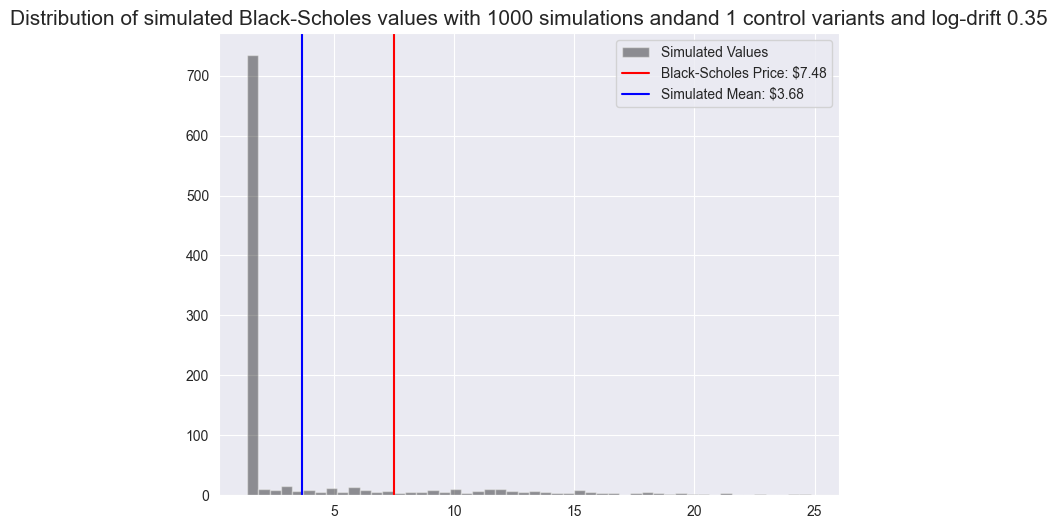

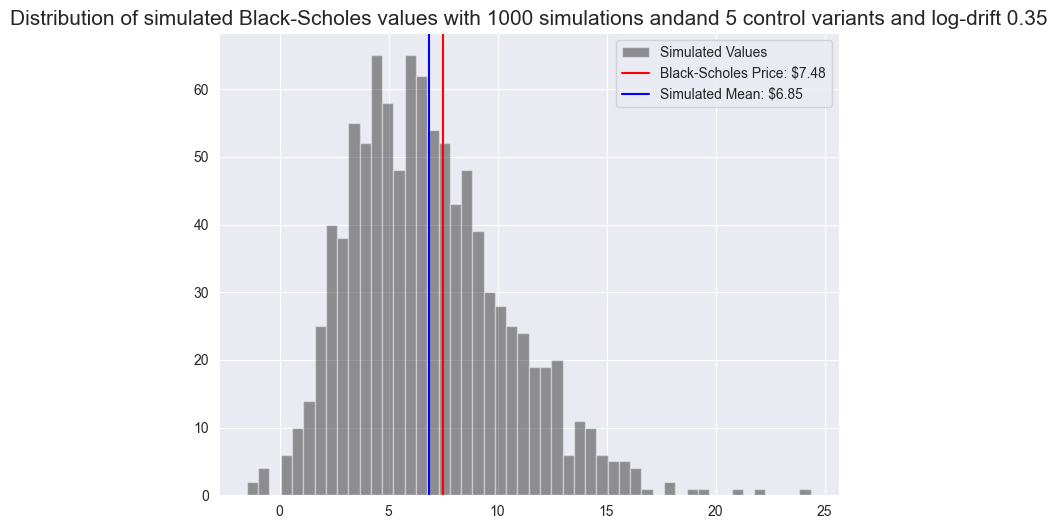

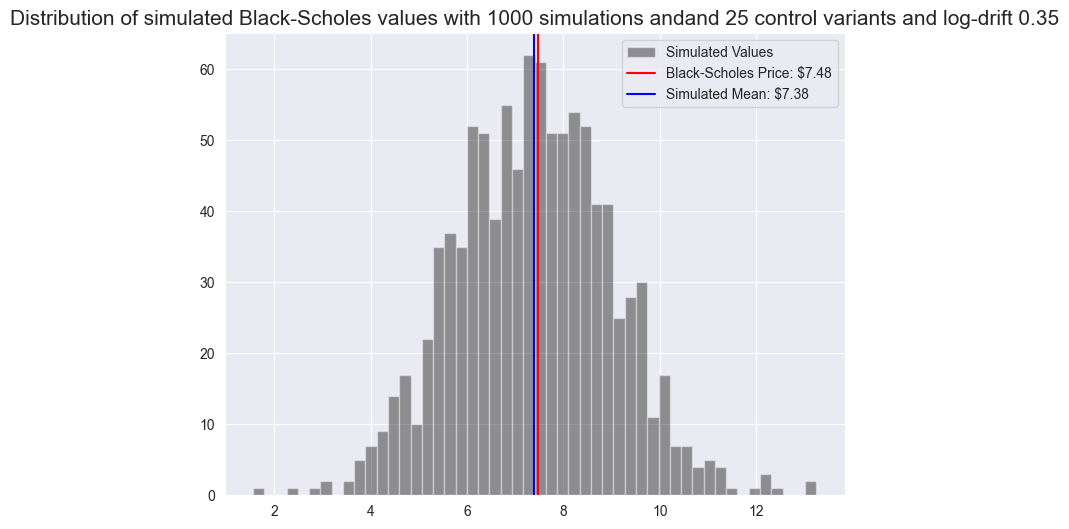

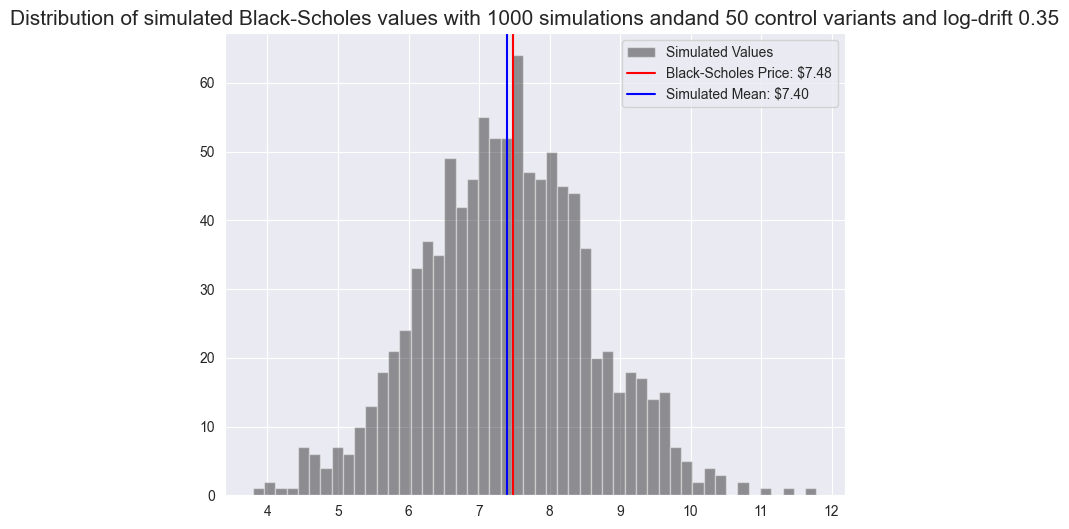

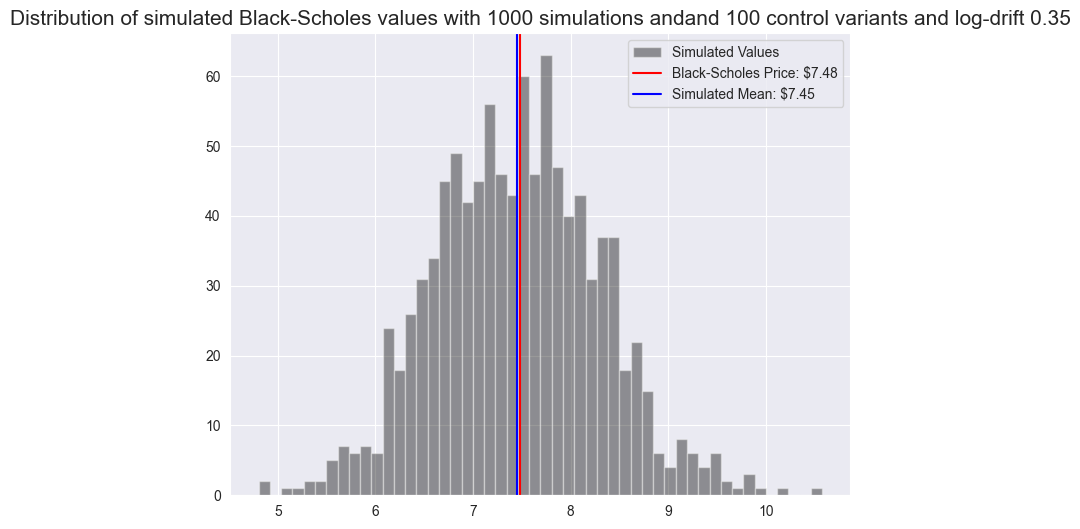

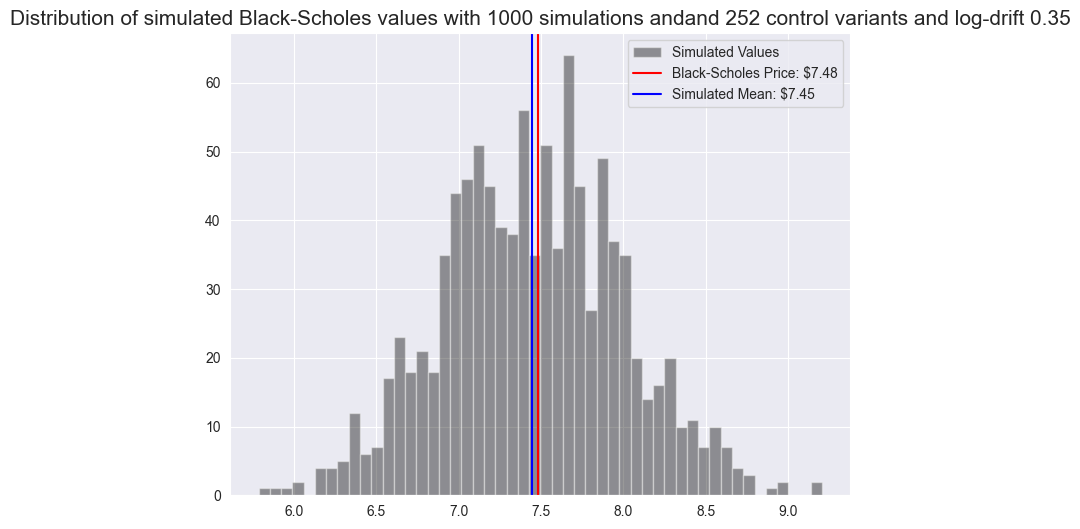

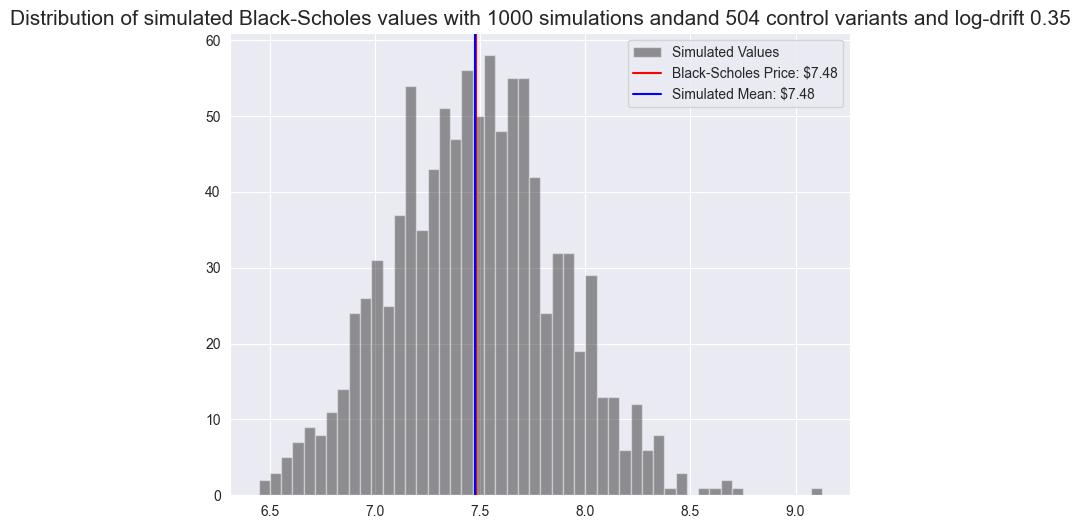

In [46]:
#Test Function and create histograms of simulated values

S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04
mu = .35 #Drift of stock movement

n_sims = 1000

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call(S0, K, sigma, r, t, mu, n_sims, n_hedges)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and\
and {n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




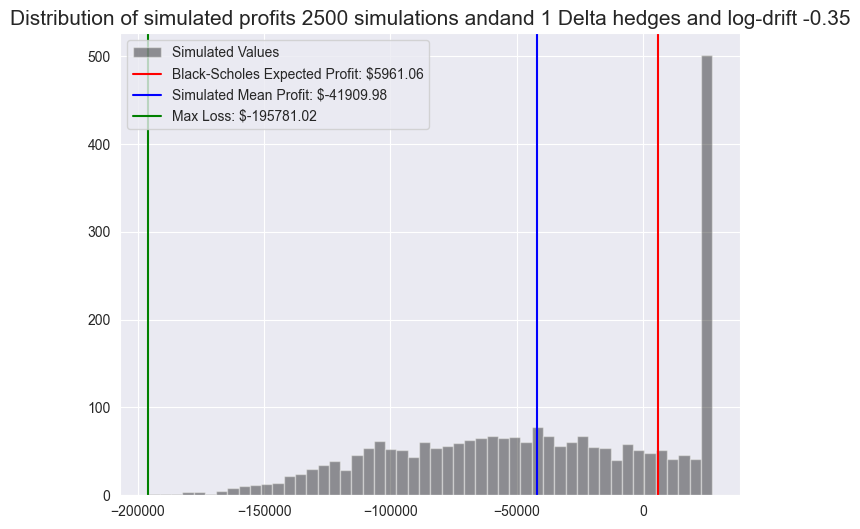

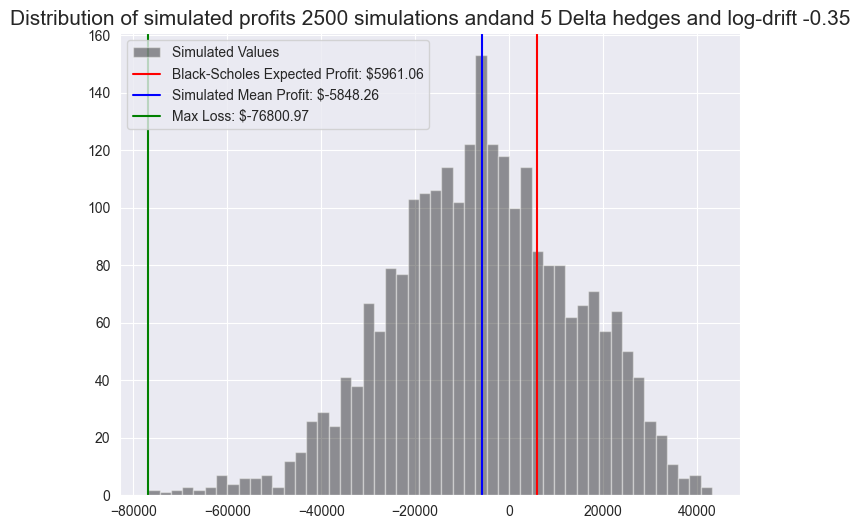

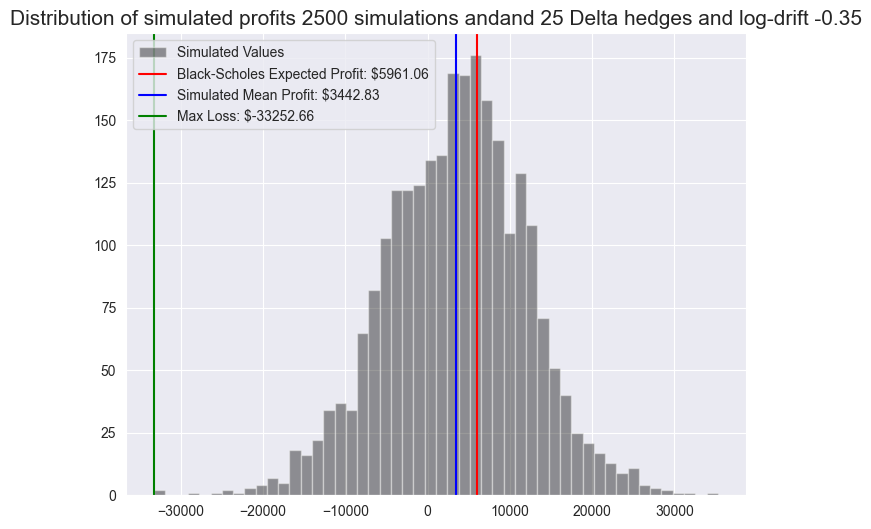

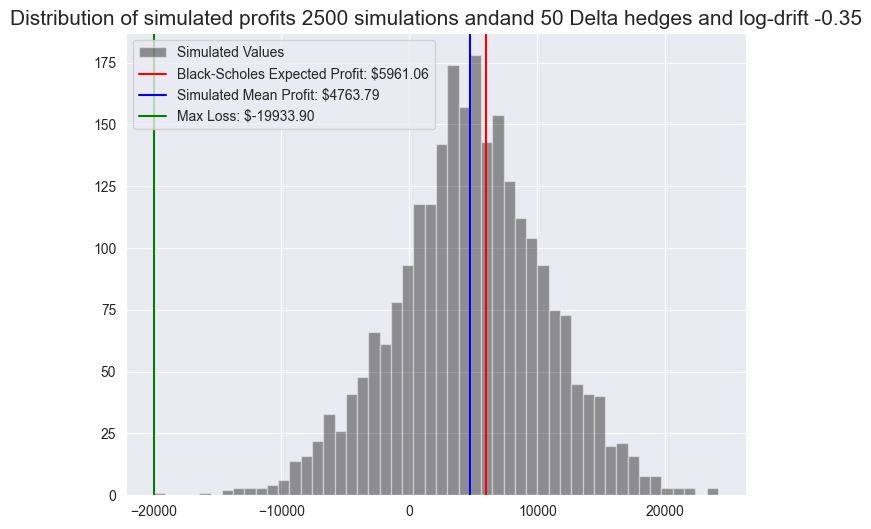

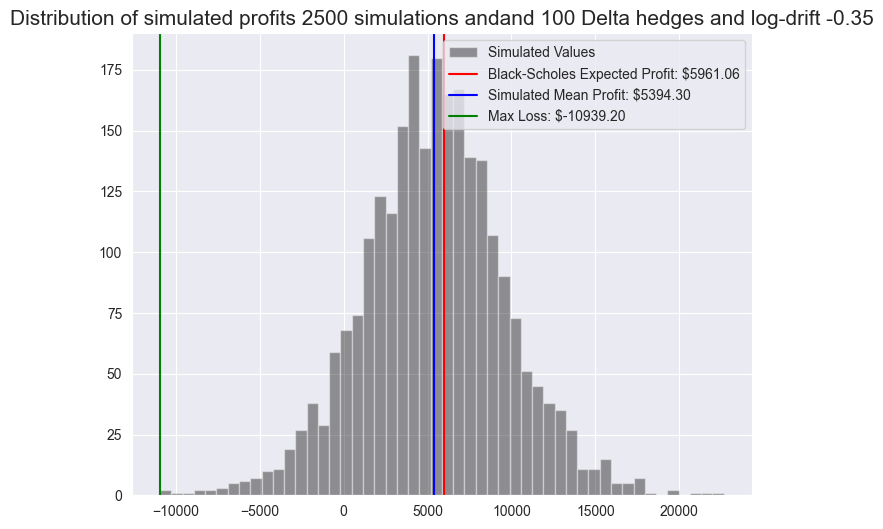

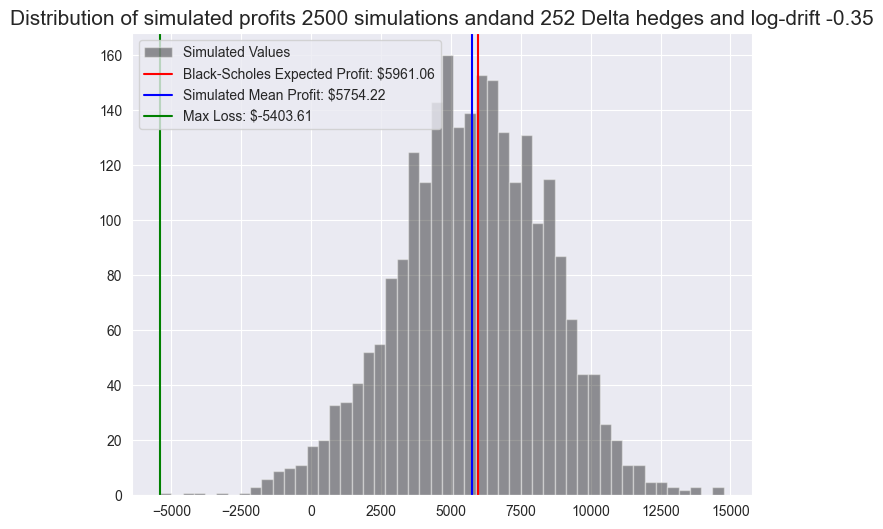

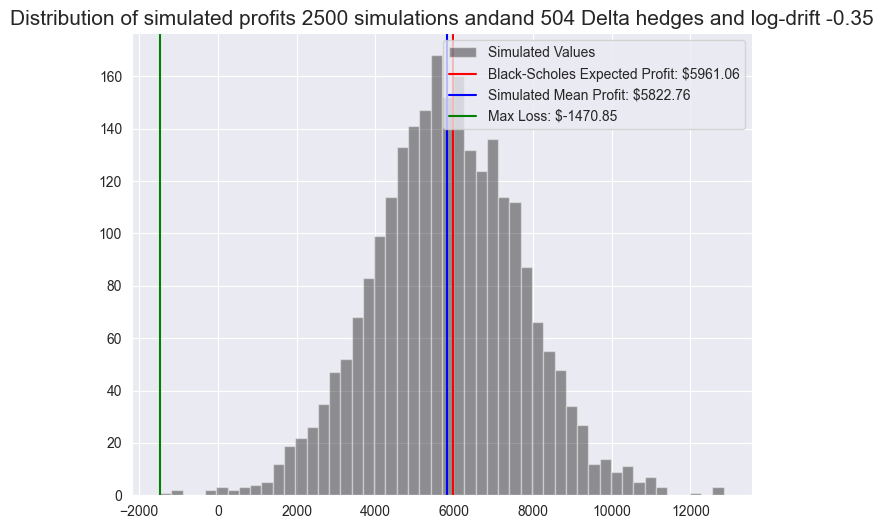

In [47]:
#Simulate and plot histograms of a seller of 100 call option contracts that receives a premium above 
#Black-Scholes Price
# Look at expected profits and max loss with varying number of hedges


S0 = 35
K = 32
sigma = .3
t = 1
r = 0.04
mu = -.35 #Drift of stock movement
premium = bs_call(S0,K,sigma + .05, t, r) #Increased volatility results in higher price in Black-Scholes model
num_options = 10000

bs_price = bs_call(S0,K,sigma,t,r)

n_sims = 2500

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

for n_hedges in hedging_numbers:
    sold_calls_hedged = bs_MC_call(S0, K, sigma, r, t, mu, n_sims, n_hedges)
    
    
    profits_hedged = num_options*(premium - sold_calls_hedged)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 50, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated profits {n_sims} simulations and\
and {n_hedges} Delta hedges and log-drift {mu}',size = 15)
    
    plt.show()


### Delta Simulation


To truly simulate payoffs of a seller of call options, or the Black-Scholes price of a call option. We need to simulate control variants in our simulation.

Instead of relying on the Black-Scholes formula for Deltas in our hedging process, we can estimate delta as follows: Let $\varepsilon>0$ and $C_0(S_0+\varepsilon), C_0(S_0-\varepsilon)$ be the Black-Scholes prices of call options with spot prices $S_0+\varepsilon$ and $S_0-\varepsilon$ respectively. Then

$$\Delta_{C_0}\approx \frac{C_0(S_0+\varepsilon) - C_0(S_0-\varepsilon)}{2\varepsilon}.$$

In [31]:
### Simulate Call Option Delta

S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04
mu = .35 #Drift of stock movement
delta_sims = 250


#simulate path endpoints

bump = .01*S0 #epsilon in above estimation

noise = np.random.normal(0,1,delta_sims)

log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

paths_up = (S0+bump)*np.exp(log_returns)

paths_down = (S0-bump)*np.exp(log_returns)

calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

delta_sims = (calls_up - calls_down)/(2*bump)


delta_estimate = np.mean(delta_sims)







print(f'Monte-Carlo Simulated Delta: {delta_estimate:.4f}')
print('-----'*17)
print('-----'*17)
print(f'Black-Scholes Delta: {bs_call_delta(S0,K,sigma,t,r):4f}')

Monte-Carlo Simulated Delta: 0.6654
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Black-Scholes Delta: 0.629300


In [33]:
#Write a function that simulates call option Delta

def bs_MC_call_delta(S0, K, sigma, t, r, delta_sims = int(250)):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Delta
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    bump = .01*S0 #epsilon in above estimation

    noise = np.random.normal(0,1,delta_sims)

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S0+bump)*np.exp(log_returns)

    paths_down = (S0-bump)*np.exp(log_returns)

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims)

    return delta_estimate
    

In [39]:
#test function
bs_MC_call_delta(S0,K,sigma,t,r,25000), bs_call_delta(S0,K,sigma,t,r)

(0.6337878538585854, 0.6293000189406536)

In [40]:
#Write a function that simulates call option Delta of spot prices in an array
def bs_MC_call_delta_array(S, K, sigma, t, r, delta_sims = 250):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Deltas in an array
    
    Parameters:
    S (np.array of floats): spot prices
    K (float): strike price
    sigma (float): volatility
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    
    bump = .01*S #epsilon in above estimation

    noise = np.random.normal(0,1,(delta_sims,len(S)))

    log_returns = (r-.5*sigma**2)*t + sigma*np.sqrt(t)*noise

    paths_up = (S+bump)*np.exp(log_returns)

    paths_down = (S-bump)*np.exp(log_returns)

    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims, axis=0)
    

    return delta_estimate



In [44]:
#Test Function

bs_MC_call_delta_array(np.array([S0, S0,S0, S0]), K ,sigma, t,r, 25000), bs_call_delta(S0,K,sigma, t,r)

(array([0.6270804 , 0.63642802, 0.62412048, 0.62935289]), 0.6293000189406536)

In [48]:
### Write a function that does a true Monte-Carlo Simulation of the Black-Scholes Call Option price 
#with Delta based control variants

def bs_MC_call(S0, K, sigma, r, t, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (float): volatility
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    noise = np.random.normal(0,1,(n_sims,n_hedges))


    #time interval between each step in simulated path
    dt = t/n_hedges

    increments = (mu+r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise #log_return increments

    log_returns = np.cumsum(increments, axis = 1)

    paths = S0*np.exp(log_returns)



    #Simulate call payouts discounted to time 0

    path_end_points = paths[:,-1]

    call_payouts = np.maximum(path_end_points - K,0)*np.exp(-r*t)



    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0
    ### We are going to cheat at the current moment in our simulation
    ### We will use the Black-Scholes formula to find Delta,
    ### We'll simulate Delta later

    delta_start = bs_MC_call_delta(S0,K,sigma,t,r,delta_sims)

    paths_first_steps = paths[:,0]

    first_stock_profits = (paths_first_steps - S0*np.exp(dt*r))*np.exp(-dt*r)

    stock_profits = []

    stock_profits.append(first_stock_profits)




    ## stock profits in intermediate steps

    for i in range(1,n_hedges):
        stock_start = paths[:,i-1]
        stock_end = paths[:,i]
        tte = t-i*dt
        deltas = bs_MC_call_delta_array(stock_start, K, sigma, tte, r,delta_sims)


        stock_profit = (stock_end - stock_start*np.exp(r*dt))*deltas*np.exp(-i*dt*r)


        stock_profits.append(stock_profit)


    total_stock_profit = np.sum(stock_profits, axis = 0)

    profits_hedged = call_payouts - total_stock_profit
    
    
    return profits_hedged


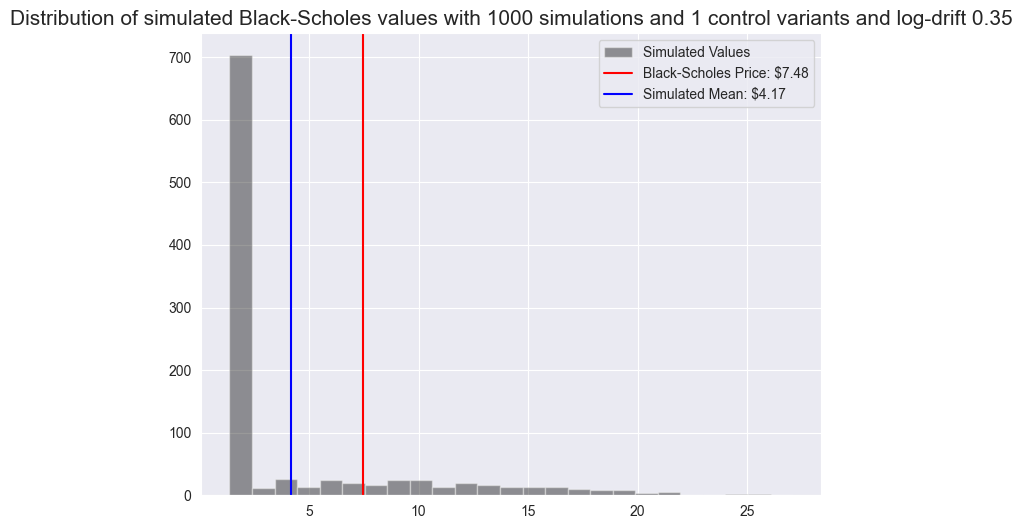

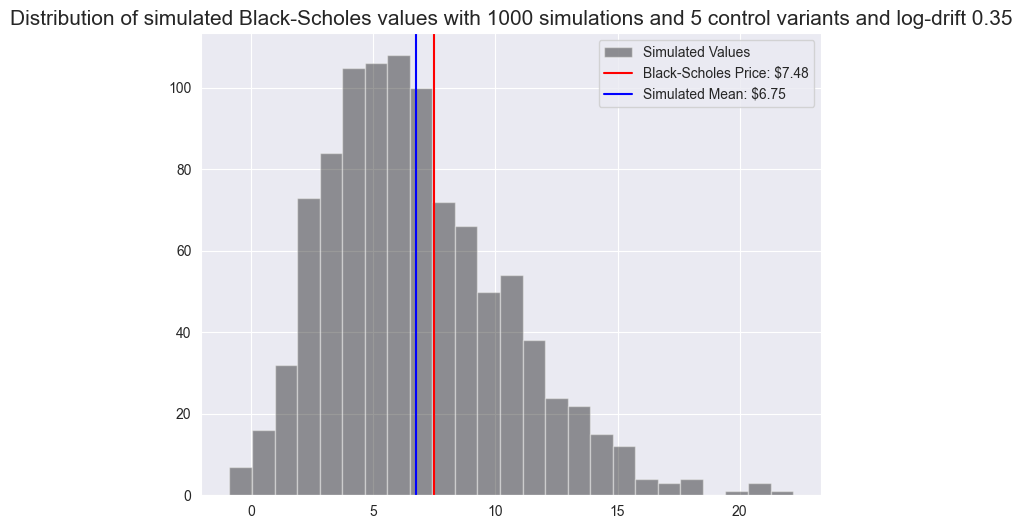

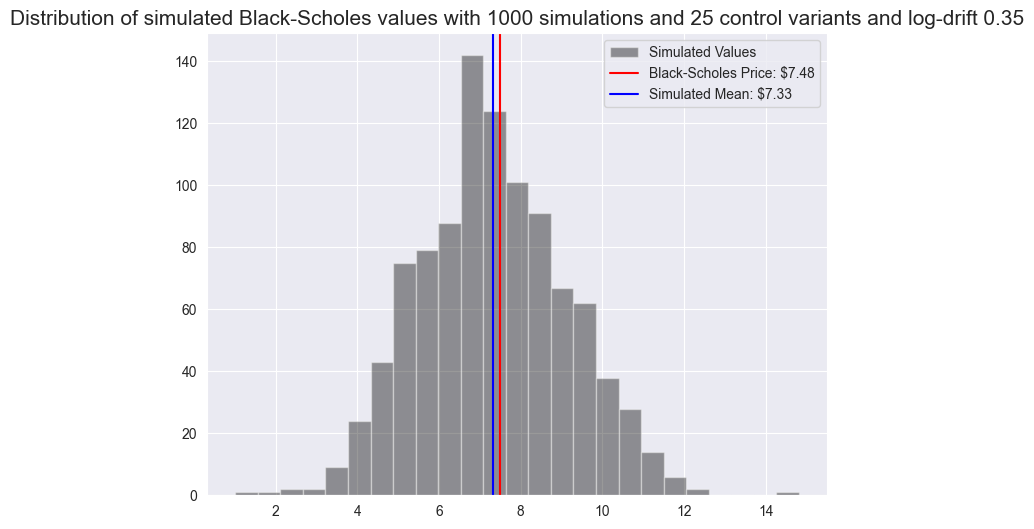

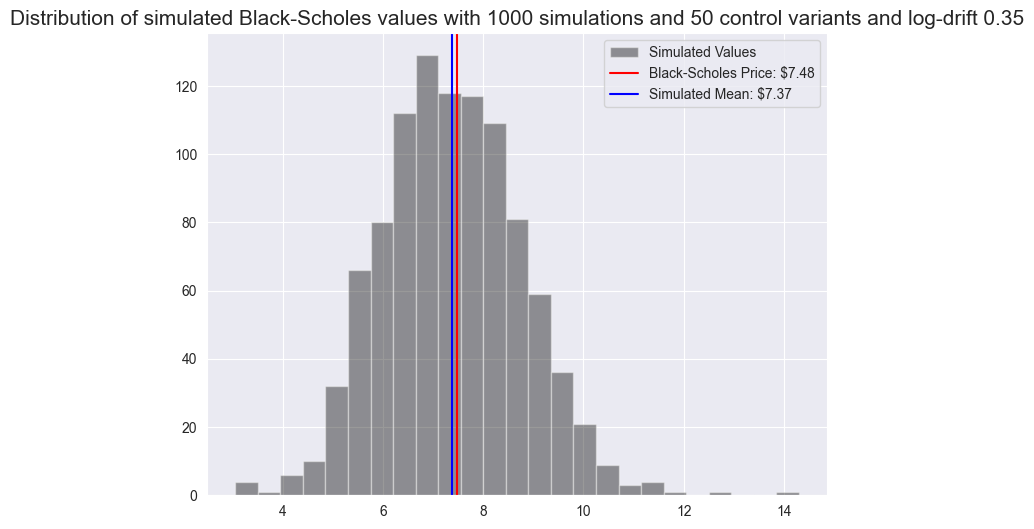

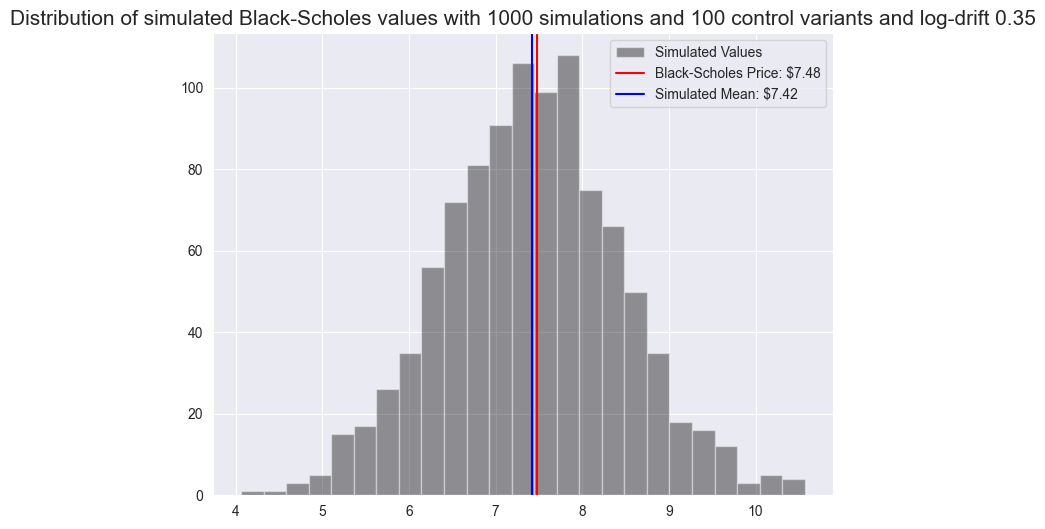

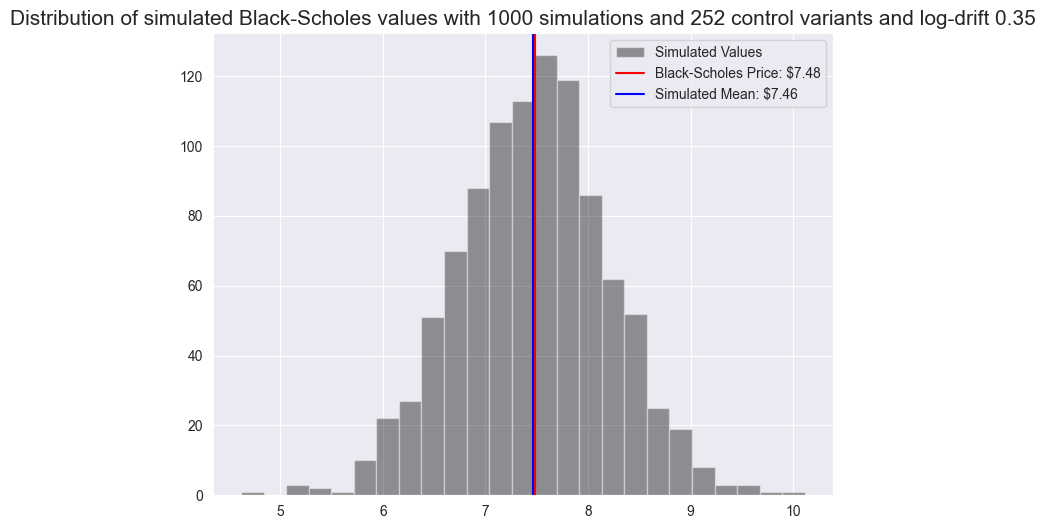

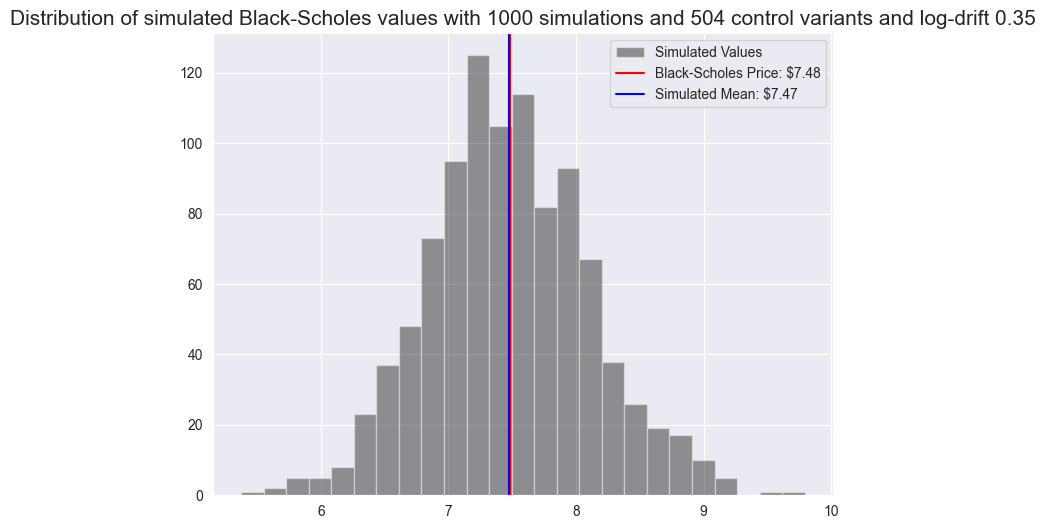

In [64]:
### Test Function

#Test Function and create histograms of simulated values

S0 = 35
K = 35
sigma = .5
t = 1
r = 0.04
mu = .35 #Drift of stock movement
delta_sims = 500

n_sims = 1000

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

bs_price = bs_call(S0,K,sigma,t,r)

for n_hedges in hedging_numbers:
    profits_hedged = bs_MC_call(S0, K, sigma, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated Black-Scholes values with {n_sims} simulations and \
{n_hedges} control variants and log-drift {mu}',size = 15)
    
    plt.show()




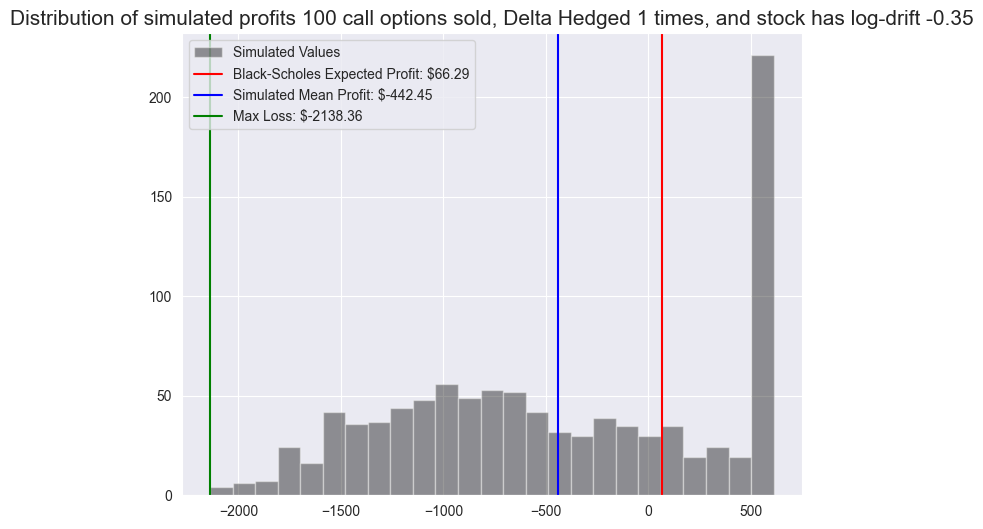

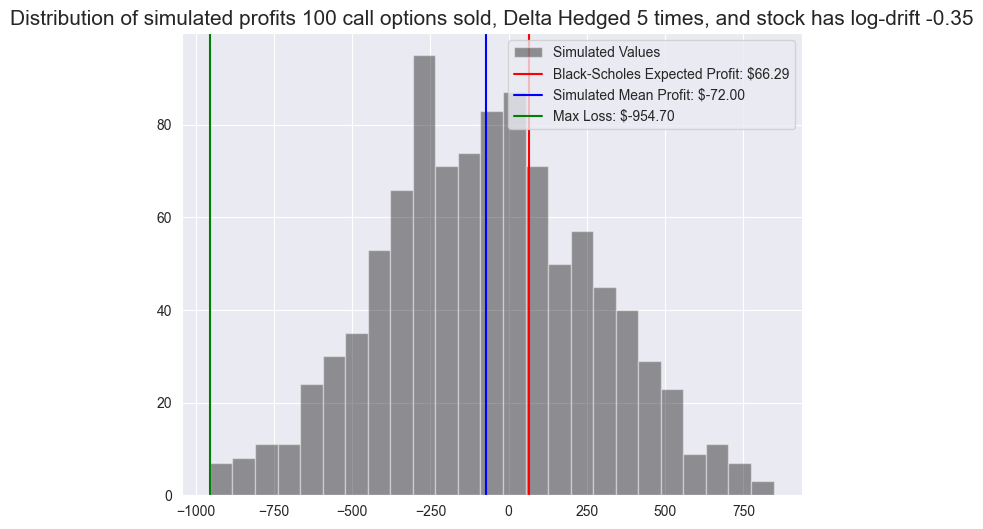

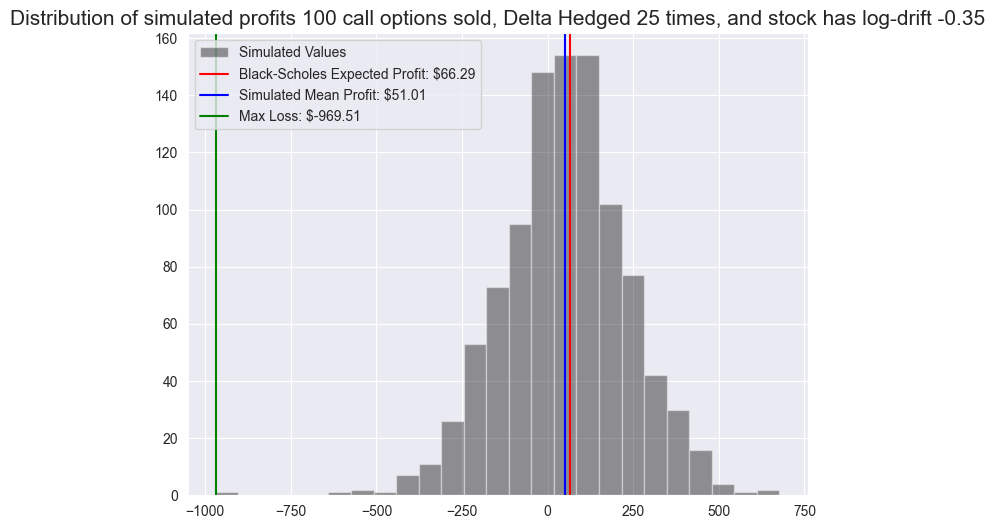

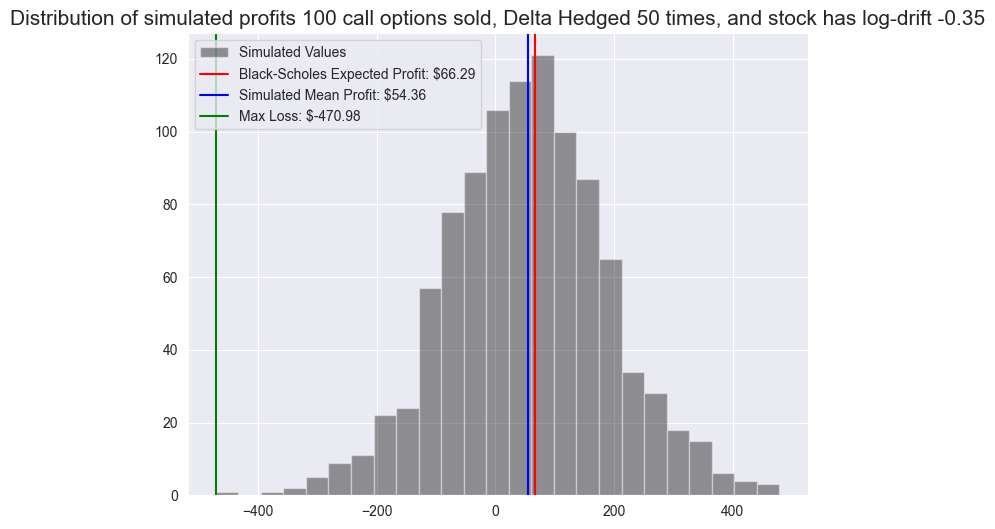

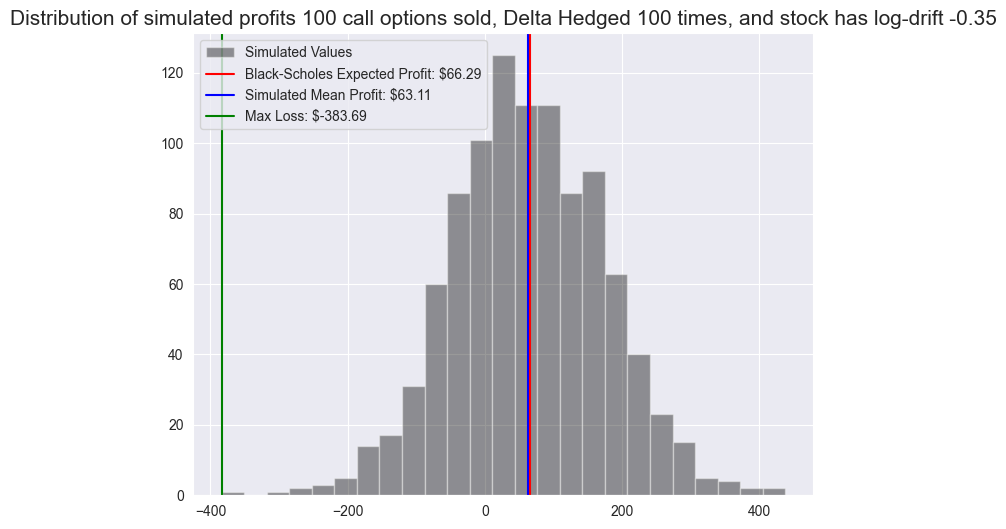

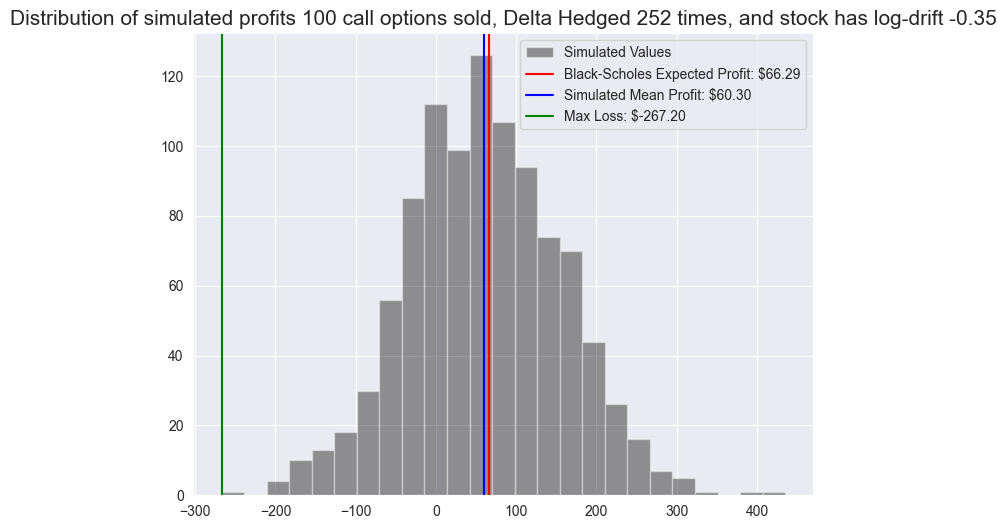

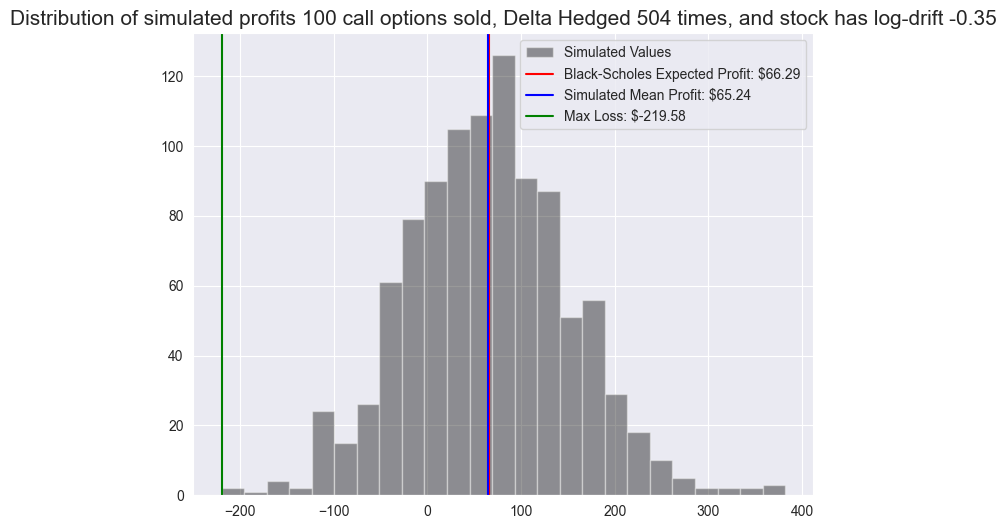

In [65]:
#True Monte-Carlo Simulation of payoffs of selling call 100 options at a premium above Black-Scholes.

S0 = 35
K = 35
sigma = .45
t = 1
r = 0.04
mu = -.35 #Drift of stock movement
premium = bs_call(S0,K,sigma + .05, t, r) #Increased volatility results in higher price in Black-Scholes model
num_options = 100

bs_price = bs_call(S0,K,sigma,t,r)

n_sims = 1000
delta_sims = 100

hedging_numbers = [1, 5, 25, 50, 100, 252, 2*252]

for n_hedges in hedging_numbers:
    sold_calls_hedged = bs_MC_call(S0, K, sigma, r, t, mu, n_sims, n_hedges, delta_sims)
    
    
    profits_hedged = num_options*(premium - sold_calls_hedged)
    
    
    plt.figure(figsize = (8,6))
    
    plt.hist(profits_hedged, bins = 25, alpha = .4, color = 'black', label = 'Simulated Values')
    
    plt.axvline(num_options*(premium-bs_price), label = f'Black-Scholes Expected Profit: ${num_options*(premium-bs_price):.2f}', color = 'red')
    
    plt.axvline(np.mean(profits_hedged), label = f'Simulated Mean Profit: ${np.mean(profits_hedged):.2f}', color = 'blue')
    
    plt.axvline(np.min(profits_hedged), label = f'Max Loss: ${np.min(profits_hedged):.2f}', color = 'green')
    
    plt.legend()
    
    plt.title(f'Distribution of simulated profits {num_options} call options sold, Delta Hedged \
{n_hedges} times, and stock has log-drift {mu}',size = 15)
    
    plt.show()


### Custom Simulations

The function `bs_MC_call`, along with the helper functions `bs_MC_call_delta` and `bs_MC_call_delta_array`, can be easily customized to accommodate more sophisticated models. These functions support two primary types of simulations:

1. **Expected Value Estimation:**  
   Simulate the expected value of a European call option under a custom model, such as one incorporating stochastic volatility, e.g. a Heston model.

2. **Hedged Payoff Distribution:**  
   Analyze the distribution of outcomes from selling a call option for a premium and implementing a delta hedging strategy over time. This enables you to model the P&L distribution of a hedged position and assess risk-adjusted performance under the custom model.

These tools provide a flexible foundation for exploring model-driven pricing and risk management strategies in quantitative finance.


In [53]:
##Sample custom model where sigma is not constant, but sigma is randomly chosen from a discrete distribution

#Write a function that simulates call option Delta with custom sigma distribution

def MC_call_delta_custom(S0, K, sigma,sigma_probs, t, r, delta_sims = int(250)):
    """Description: 
    Monte-Carlo Simulation of Black-Scholes Call Delta
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    
    """
    bump = .01*S0

    noise = np.random.normal(0,1,delta_sims)
    
    sampled_sigma = np.random.choice(sigma,p=sigma_probs,size=delta_sims)

    log_returns = (r - .5*sampled_sigma**2)*t + sampled_sigma*np.sqrt(t)*noise

    paths_up = (S0+bump)*np.exp(log_returns)
    paths_down = (S0-bump)*np.exp(log_returns)

    call_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)
    call_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    simulated_deltas = (call_up-call_down)/(2*bump)

    return np.mean(simulated_deltas)




    
def MC_call_delta_custom_array(S, K, sigma, sigma_probs, t, r, delta_sims=250):
    """
    Monte Carlo estimation of Black-Scholes call deltas for an array of spot prices
    with stochastic volatility model (discrete distribution).
    
    Parameters:
    S (np.array): array of spot prices
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    t (float): time to expiration
    r (float): risk-free interest rate
    delta_sims (int): Number of simulations
    
    Return
    float: simulated delta of call option
    """
    bump = 0.01 * S
    noise = np.random.normal(0, 1, (delta_sims, len(S)))

    sampled_sigma = np.random.choice(sigma, p=sigma_probs, size=(delta_sims, len(S)))
    log_returns = (r - 0.5 * sampled_sigma**2) * t + sampled_sigma * np.sqrt(t) * noise

    paths_up = (S + bump) * np.exp(log_returns)
    paths_down = (S - bump) * np.exp(log_returns)

    call_up = np.maximum(paths_up - K, 0) * np.exp(-r * t)
    call_down = np.maximum(paths_down - K, 0) * np.exp(-r * t)

    deltas = (call_up - call_down) / (2 * bump)
    return np.mean(deltas, axis=0)




def MC_call_custom_sigma(S0, K, sigma, sigma_probs, t, r, mu = 0, n_sims = 2500, n_hedges = 50, delta_sims = 250):
    
    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants
    
    
    Parameters:
    S0 (float): spot price
    K (float): strike price
    sigma (array): array of volatilities
    sigma_probs (array): probabilities of sigmas
    r (float): risk-free interest rate
    t (float): time to expiration
    mu (float): Drift of log-returns
    n_sims (int): Number of simulations
    n_hedges (int): number of delta control variants at evenly spaced increments
    
    
    Return:
    np.array of simulated values of Black-Scholes value of call option
    
    Warning:
    This function is not a true simulation. The Black-Scholes equation for Delta is not simulated.
    """
    
    #Create random noise for n_sims number of paths with n_hedges steps in simulated stock movements
    noise = np.random.normal(0,1, (n_sims,n_hedges))

    dt = t/n_hedges #time interval between each step in simulated path
    sampled_sigma = np.random.choice(sigma, p = sigma_probs,size = (n_sims,n_hedges))


    exponent = (mu + r - .5*sampled_sigma**2)*dt + sampled_sigma*np.sqrt(dt)*noise

    log_returns = np.cumsum(exponent, axis = 1)

    paths = S0*np.exp(log_returns)


    #Simulate call payoffs discounted to time 0

    path_ends = paths[:,-1] 

    call_payoffs = np.maximum(path_ends - K, 0)*np.exp(-r*t)


    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0

    paths_first_step = paths[:,0]

    delta_start = MC_call_delta_custom(S0,K,sigma,sigma_probs,t,r,delta_sims)

    stock_profits_start = (paths_first_step - np.exp(r*dt)*S0)*delta_start*np.exp(-r*dt)

    total_stock_profits = []

    total_stock_profits.append(stock_profits_start)

    ## stock profits in intermediate steps
    for i in range(1,n_hedges):
        path_starts = paths[:,i-1]
        path_ends = paths[:,i]
    #time to expiration from starting point 
    #needed to find delta of option and how much stock should be held to be delta neutral until next step
        tte = t - i*dt 
        deltas = MC_call_delta_custom_array(path_starts, K, sigma,sigma_probs, tte, r,delta_sims)
        stock_profit = (path_ends - path_starts*np.exp(r*dt))*deltas*np.exp(-r*(i+1)*dt)
        total_stock_profits.append(stock_profit)



    stock_profits = np.sum(total_stock_profits, axis = 0)
    
    profits_hedged = call_payoffs - stock_profits
    
    return profits_hedged

In [67]:
#Test Function
S0 = 35
K = 35
sigma = [.22, .35, .45]
sigma_probs = [.4, .4, .2]
t = 1
r = 0.04
mu = 0 #Drift of stock movement
n_sims = 15000
n_hedges = 15
delta_sims = 100


profits_hedged = MC_call_custom_sigma(S0, K, sigma, sigma_probs, t, r, mu, n_sims, n_hedges, delta_sims)


print(f'Simulated option value under custom volatility distribution: ${np.mean(profits_hedged):.2f} \
and standard error {np.std(profits_hedged)/np.sqrt(n_sims):.6f}')

sigma_avg = .22*.4 + .35*.4 + .45*.2

print('----'*17)
print('----'*17)


print(f'Black-Scholes Price with volatility the average of custom volatility distribution \
${bs_call(S0,K,sigma_avg,t,r):.2f}.')

Simulated option value under custom volatility distribution: $5.18 and standard error 0.010426
--------------------------------------------------------------------
--------------------------------------------------------------------
Black-Scholes Price with volatility the average of custom volatility distribution $5.06.
